<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Launch Sites Locations Analysis with Folium**


Estimated time needed: **40** minutes


The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.


In the previous exploratory data analysis labs, you have visualized the SpaceX launch dataset using `matplotlib` and `seaborn` and discovered some preliminary correlations between the launch site and success rates. In this lab, you will be performing more interactive visual analytics using `Folium`.


## Objectives


This lab contains the following tasks:

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.


Let's first import required Python packages for this lab:


In [2]:
!pip3 install folium
!pip3 install wget

/home/merk/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01
/home/merk/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=48d06db0b4589b0d71dbfa525eba3622c4412413e615db058e4c85d8d400519d
  Stored in directory: /home/merk/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [131]:
import folium
import wget
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

If you need to refresh your memory about folium, you may download and refer to this previous folium lab:


[Generating Maps with Python](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module\_3/DV0101EN-3-5-1-Generating-Maps-in-Python-py-v2.0.ipynb)


## Task 1: Mark all launch sites on a map


First, let's try to add each site's location on a map using site's latitude and longitude coordinates


The following dataset with the name `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site.


In [35]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)

Now, you can take a look at what are the coordinates for each site.


In [57]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
# spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
sdf = pd.DataFrame(spacex_df)
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df
# sdf.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.


In [359]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example,


In [374]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

and you should find a small yellow circle near the city of Houston and you can zoom-in to see a larger circle.


Now, let's add a circle for each launch site in data frame `launch_sites`


*TODO:*  Create and add `folium.Circle` and `folium.Marker` for each launch site on the site map


An example of folium.Circle:


`folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(...))`


An example of folium.Marker:


`folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'label', ))`


In [375]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label



for line_num, col in enumerate(launch_sites_df.index):
#     if line_num != 
    row = launch_sites_df.iloc[col]
    site, lat, long = row
    coords = [lat, long]    
    
    site_map.add_child(folium.Circle(coords, radius=1000, color='orange', fill=True).add_child(folium.Popup(site)))
    # Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
    
    site_map.add_child(folium.map.Marker(
        coords,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 15; color:black;"><b>{site}</b></div>',
            )
        ))
# print("Done Adding Markers")
site_map.add_child(circle)
site_map.add_child(marker)

The generated map with marked launch sites should look similar to the following:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_markers.png" />
</center>


Now, you can explore the map by zoom-in/out the marked areas
, and try to answer the following questions:

*   Are all launch sites in proximity to the Equator line?
*   Are all launch sites in very close proximity to the coast?

Also please try to explain your findings.


# Task 2: Mark the success/failed launches for each site on the map


Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates.
Recall that data frame spacex_df has detailed launch records, and the `class` column indicates if this launch was successful or not


In [376]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


Next, let's create markers for all launch records.
If a launch was successful `(class=1)`, then we use a green marker and if a launch was failed, we use a red marker `(class=0)`


Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.


Let's first create a `MarkerCluster` object


In [377]:
marker_cluster = MarkerCluster()



*TODO:* Create a new column in `launch_sites` dataframe called `marker_color` to store the marker colors based on the `class` value


In [378]:
marker_color = ['green' if success == 1 else 'red' for success in spacex_df['class']]


In [379]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
# spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
# Above is commented out because I like my way better an unecessary function was used.
# Method used was list comprehension of the dataframe shown below:
# marker_color = ['green' if success == 1 else 'red' for success in spacex_df['class']]
spacex_df['marker_color'] = marker_color
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


*TODO:* For each launch result in `spacex_df` data frame, add a `folium.Marker` to `marker_cluster`


In [380]:
# Add marker_cluster to current site_map
# site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

marker_cluster = MarkerCluster()
site_map.add_child(marker_cluster)
# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    site, lat, long, clss, color = record
    coords = [lat, long]
    site_map.add_child(folium.Circle(coords, radius=200, color=color, fill=True).add_child(folium.Popup(site)))
    
    # TODO: Create and add a Marker cluster to the site map
    marker = folium.Marker(
    tooltip=f"{site}: {clss}",
    location=coords,
    popup=site,
    # Create an icon as a text label
    icon=folium.Icon(
        popup=site,
        location=coords,
        icon_size=(20,20),
        icon_anchor=(0,0),
        color=color,
        html=f'<div style="font-size: 12; color:{color};"><b></b></div>',
        )
    )
    marker_cluster.add_child(marker)

site_map

Your updated map may look like the following screenshots:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster.png" />
</center>


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster_zoomed.png" />
</center>


From the color-labeled markers in marker clusters, you should be able to easily identify which launch sites have relatively high success rates.


# TASK 3: Calculate the distances between a launch site to its proximities


Next, we need to explore and analyze the proximities of launch sites.


Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [381]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.


You can calculate the distance between two points on the map based on their `Lat` and `Long` values using the following method:


In [382]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

*TODO:* Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.


In [383]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
# coastline_lat = 34.6353
# coastline_lon = -120.62465
coastline_lat = 28.56311
coastline_lon = -80.56792
def get_shortest_distance(coastline_lat, coastline_lon):
    d = None
    shortest = 19999999999999999999999
#     shortest_index = 0
    
    for line_num, col in enumerate(launch_sites_df.index):
        row = launch_sites_df.iloc[col]
        site, lat, long = row
        launch_site_lat = lat
        launch_site_lon = long
        distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
        if distance_coastline < shortest:
            shortest = distance_coastline
            d = {'row': row, 'distance': distance_coastline}
    
    return {'lat': d['row']['Lat'], 'long': d['row']['Long'], 'site': d['row']['Launch Site'], 'distance': d['distance']}
            
        
    
closest = get_shortest_distance(coastline_lat, coastline_lon)
print("closest: ", closest)

closest:  {'lat': 28.56319718, 'long': -80.57682003, 'site': 'CCAFS SLC-40', 'distance': 0.8695168807140676}


*TODO:* After obtained its coordinate, create a `folium.Marker` to show the distance


In [384]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
# for example

distance = closest['distance']
coordinate = [coastline_lat, coastline_lon]
print("COORDINATES: ", coordinate)
distance_marker = folium.Marker(
   coordinate,
   icon=DivIcon(
       icon_size=(0, 0),
       icon_anchor=coordinate,
       html='<div style="font-size: 15; color:green;"><b>%s</b></div>' %"{:10.2f} KM".format(distance),
       )
   )
site_map.add_child(distance_marker)

COORDINATES:  [28.56311, -80.56792]


*TODO:* Draw a `PolyLine` between a launch site to the selected coastline point


In [385]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
coastline_lat, coastline_lon = coastline_lat, coastline_lon
coordinates = ((closest['lat'], closest['long']),(coastline_lat, coastline_lon))
lines=folium.PolyLine(locations=coordinates, weight=1, tooltip=distance)

site_map.add_child(lines)

Your updated map with distance line should look like the following screenshot:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_distance.png" />
</center>


*TODO:* Similarly, you can draw a line betwee a launch site to its closest city, railway, highway, etc. You need to use `MousePosition` to find the their coordinates on the map first


A railway map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/railway.png" />
</center>


A highway map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/highway.png" />
</center>


A city map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/city.png" />
</center>


In [386]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site
hwy_lat = 28.57215
hwy_long = -80.57211
distance = calculate_distance(hwy_lat, hwy_long, closest['lat'], closest['long'])
coordinates = ((hwy_lat, hwy_long), (closest['lat'], closest['long']))
lines=folium.PolyLine(locations=coordinates, weight=1, tooltip=distance)

site_map.add_child(lines)

distance_marker2 = folium.Marker(
   (hwy_lat, hwy_long),
   icon=DivIcon(
       icon_size=(0, 0),
       icon_anchor=(hwy_lat, hwy_long),
       html='<div style="font-size: 15; color:green;"><b>Samuel C Phillips Parkway</b></div>',
       )
   )
site_map.add_child(distance_marker2)
site_map


In [135]:
df = pd.DataFrame(sdf)
df.head()
ksc = df[df['Launch Site'] == "KSC LC-39A"]
ksc.value_counts()

Flight Number  Date        Time (UTC)  Booster Version  Launch Site  Payload                Payload Mass (kg)  Orbit      Customer            Landing Outcome       class  Lat        Long        Year
54             2018-05-11  20:14:00    F9 B5  B1046.1   KSC LC-39A   Bangabandhu-1          3600.00            GTO        Thales-Alenia/BTRC  Success (drone ship)  1      28.573255  -80.646895  2018    1
44             2017-10-30  19:34:00    F9 B4 B1042.1    KSC LC-39A   Koreasat 5A            3500.00            GTO        KT Corporation      Success (drone ship)  1      28.573255  -80.646895  2017    1
43             2017-10-11  22:53:00    F9 FT  B1031.2   KSC LC-39A   SES-11 / EchoStar 105  5200.00            GTO        SES EchoStar        Success (drone ship)  1      28.573255  -80.646895  2017    1
41             2017-09-07  14:00:00    F9 B4 B1040.1    KSC LC-39A   Boeing X-37B OTV-5     4990.00            LEO        U.S. Air Force      Success (ground pad)  1      28.573255  -80.646

18


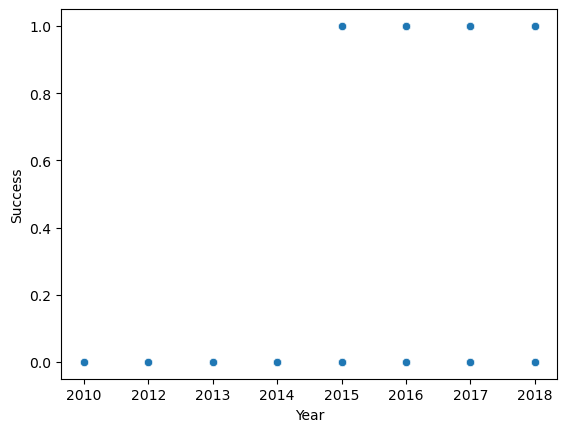

In [124]:
# print(df.dtypes)
def get_year(x):
    x = str(x)
#     print("X: ", x)
    year = x[0:4]
#     print("YEAR: ", year)
    return year

def get_success(x):
    if x == 1:
        return 1
    else: 
        return 0
    
def get_failure(x):
    if x == 0:
        return 1
    else: 
        return 0
    
    
    
df['Year'] = df['Date'].apply(get_year)

# _2015 = df[df['Year'] == '2015']
df['Success'] = df['class'].apply(get_success)
df['Failure'] = df['class'].apply(get_failure)
sns.scatterplot(x=df['Year'], y=df['Success'])
plt.plot()




is2017 = df[df['Year'] == '2017']
print(len(is2017.index))
# df['Year']

,Success,Failure
Year,,
2010,0,2
2012,0,2
2013,0,3
2014,0,6
2015,2,5
2016,5,3
2017,14,4
2018,3,7


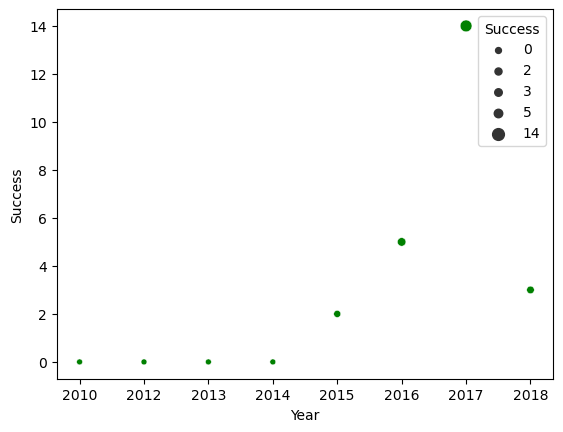

In [133]:
df.head()
s = df.groupby('Year').sum()

sns.scatterplot(x=s.index, y=s['Success'], size=s['Success'], color="green")
plt.plot()
s[['Success', 'Failure']]

,Success,Failure
Year,,
2010,0,2
2012,0,2
2013,0,3
2014,0,6
2015,2,5
2016,5,3
2017,14,4
2018,3,7


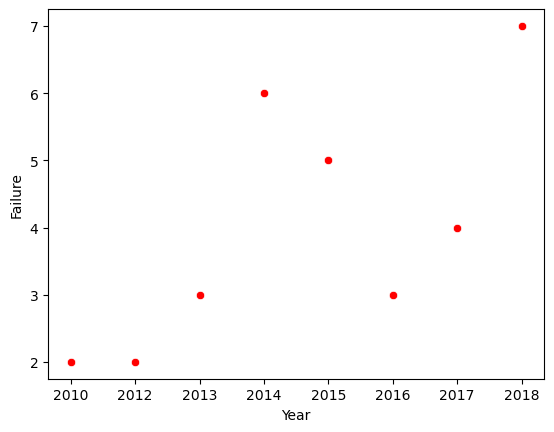

In [139]:
sns.scatterplot(x=s.index, y=s['Failure'], color="red")
plt.plot()
s[['Success', 'Failure']]

,Flight Number,Payload Mass (kg),class,Lat,Long,Success,Failure,sfmean
Year,,,,,,,,
2010,3,0.00,0,57.124604,-161.154713,0,2,1.0
2012,7,1025.00,0,57.124604,-161.154713,0,2,1.0
2013,18,4347.00,0,91.757438,-281.765458,0,3,1.5
2014,63,18116.00,0,171.373812,-483.464139,0,6,3.0
2015,119,17715.00,2,199.936114,-564.041495,2,5,3.5
2016,196,27213.00,5,234.568948,-684.652241,5,3,4.0
2017,675,94374.65,14,544.606423,-1651.393291,14,4,9.0
2018,515,44221.65,3,303.850940,-925.940052,3,7,5.0


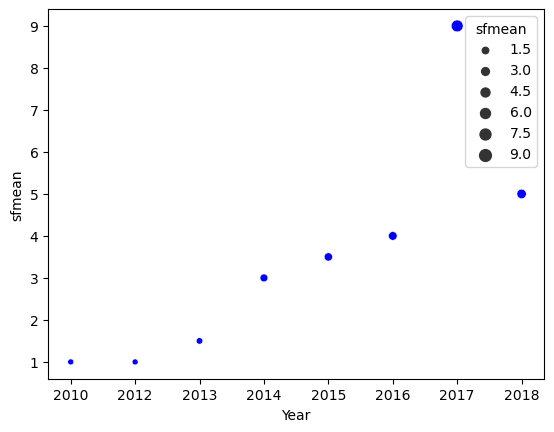

In [159]:
s['sfmean'] = (s['Success'] + s['Failure']) / 2
sns.scatterplot(x=s.index, y=s['sfmean'], color="blue", size=s['sfmean'])
plt.plot()
s


,Flight Number,Payload Mass (kg),class,Lat,Long,Success,Failure,sfmean,sf
Year,,,,,,,,,
2010,3,0.00,0,57.124604,-161.154713,0,2,1.0,2.0
2012,7,1025.00,0,57.124604,-161.154713,0,2,1.0,2.0
2013,18,4347.00,0,91.757438,-281.765458,0,3,1.5,3.0
2014,63,18116.00,0,171.373812,-483.464139,0,6,3.0,6.0
2015,119,17715.00,2,199.936114,-564.041495,2,5,3.5,3.0
2016,196,27213.00,5,234.568948,-684.652241,5,3,4.0,2.0
2017,675,94374.65,14,544.606423,-1651.393291,14,4,9.0,10.0
2018,515,44221.65,3,303.850940,-925.940052,3,7,5.0,4.0


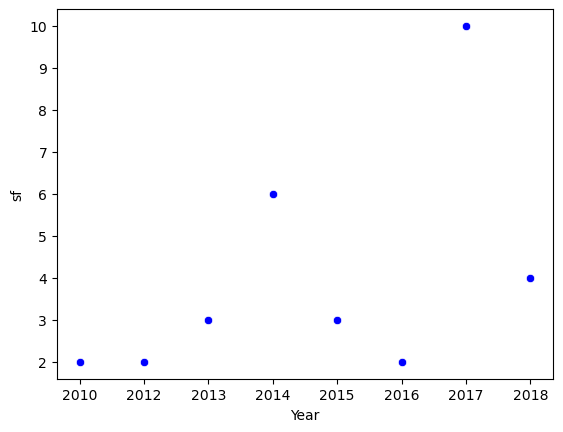

In [132]:
s['sf'] = np.sqrt((s['Success'] - s['Failure'])**2)
sns.scatterplot(x=s.index, y=s['sf'], color="blue")
plt.plot()
s

In [141]:
success = df[df['class'] == 1]
# success

In [140]:
failure = df[df['class'] == 0]
# failure

In [158]:
best_booster = df.groupby(['Booster Version', 'class'], as_index=False)['class'].sum()
best_booster

,Booster Version,class
0,F9 B4 B1039.2,0
1,F9 B4 B1040.2,0
2,F9 B4 B1041.2,0
3,F9 B4 B1043.2,0
4,F9 B4 B1039.1,1
5,F9 B4 B1040.1,1
6,F9 B4 B1041.1,1
7,F9 B4 B1042.1,1
8,F9 B4 B1043.1,1
9,F9 B4 B1044,0


After you plot distance lines to the proximities, you can answer the following questions easily:

*   Are launch sites in close proximity to railways?
*   Are launch sites in close proximity to highways?
*   Are launch sites in close proximity to coastline?
*   Do launch sites keep certain distance away from cities?

Also please try to explain your findings.


# Next Steps:

Now you have discovered many interesting insights related to the launch sites' location using folium, in a very interactive way. Next, you will need to build a dashboard using Ploty Dash on detailed launch records.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


### Other Contributors


Joseph Santarcangelo


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |
| ----------------- | ------- | ---------- | --------------------------- |
| 2021-05-26        | 1.0     | Yan        | Created the initial version |


Copyright © 2021 IBM Corporation. All rights reserved.
